# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing surprise library**

In [ ]:
!pip install surprise

## **Importing the necessary libraries and overview of the dataset**

In [ ]:
#libraries for data processing
import pandas as pd
import numpy as np
#libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
#libraries for recommendation systems
from collections import defaultdict
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import KNNBasic
from surprise.model_selection import KFold
from surprise import accuracy
from surprise.prediction_algorithms import SVD
from surprise.model_selection import GridSearchCV

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [ ]:
#loading the data
data=pd.read_csv('/content/drive/MyDrive/MIT Data Science/Recommendation Systems/ratings_Electronics.csv')

In [ ]:
#reading the data
data.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


Our dataset is made up of product and user ID #'s, a ratings column, and an additional column which is most likely a timestamp

In [ ]:
#getting the size of the dataset
data.shape

(7824481, 4)

The dataset is composed of 7,824,481 rows and 4 columns.  Its very large.

In [ ]:
#getting our dtypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
 #   Column         Dtype  
---  ------         -----  
 0   AKM1MP6P0OYPR  object 
 1   0132793040     object 
 2   5.0            float64
 3   1365811200     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [ ]:
#adding column headers
data.columns=['user_id','prod_id','rating','timestamp']

In [ ]:
#convert our object columns to strings
data['user_id']=data['user_id'].astype(str)
data['prod_id']=data['prod_id'].astype(str)

In [ ]:
data.head()

,user_id,prod_id,rating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [ ]:
#dropping the timestamp column
data = data.drop('timestamp', axis=1)

In [ ]:
data.head()

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


In [ ]:
#making a copy of our dataframe
df=data.copy()

**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [ ]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [ ]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [ ]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [ ]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [ ]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [ ]:
#checking the size of the dataset
df_final.shape

(65290, 3)

**Our dataset has now been trimmed down to 65,290 rows**





### **Data types**

In [ ]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


**user_id and prod_id are object, and rating is a float**

### **Checking for missing values**

In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

,0
user_id,0
prod_id,0
rating,0


**We have a complete dataset with no missing values**

### **Summary Statistics**

In [ ]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Our data shows a skewed mean rating of nearly 4.3 (on a scale of 1-5), with a range of ratings spanning the entire scale**

### **Checking the rating distribution**

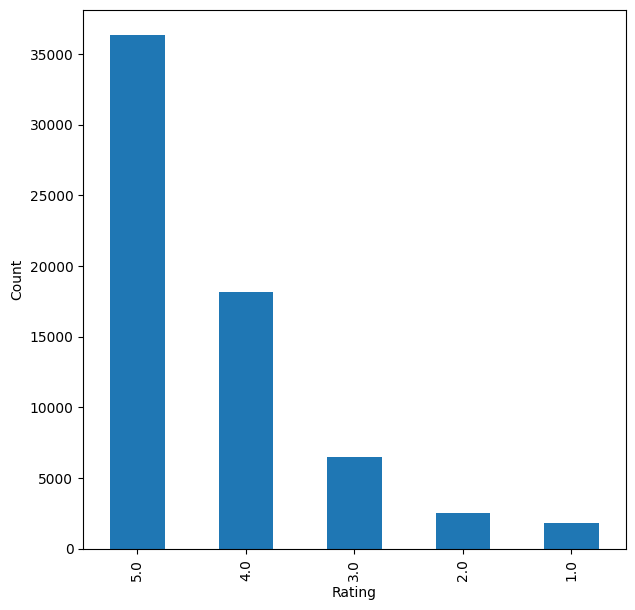

In [ ]:
# Create the bar plot and provide observations

plt.figure(figsize=(7,7))

df_final['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')
plt.show()

**As stated above, the distribution of ratings is heavily skewed towards higher ratings relative to low (<3) ratings**

### **Checking the number of unique users and items in the dataset**

In [ ]:
# Number of total rows in the data and number of unique user id and product id in the data
df_final.nunique()

,0
user_id,1540
prod_id,5689
rating,5


**Our dataset is mostly comprised of repeat customers and approximately 5700 products on a 5 point rating scale.**

### **Users with the most number of ratings**

In [ ]:
# Top 10 users based on the number of ratings
df_final['user_id'].value_counts().head(10)

,count
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A1UQBFCERIP7VJ,193
A22CW0ZHY3NJH8,193
AWPODHOB4GFWL,184


**We have multiple users with over 200 product ratings.  The Top 5 Users (in terms of number of ratings) are:

-ADLVFFE4VBT8

-A3OXHLG6DIBRW8

-A1ODOGXEYECQQ8

-A36K2N527TXXJN

-A25C2M3QF9G7OQ**

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculating average ratings
average_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculating the count of ratings
count_rating = df_final.groupby('prod_id')['rating'].count()

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})


# Sort the dataframe by average of ratings in the descending order and viewing the first five records
final_rating.sort_values('avg_rating', ascending=False).head()




,avg_rating,rating_count
prod_id,,
B005NC8BF6,5.0,5
B00000K4KH,5.0,5
B00000DM9W,5.0,5
B00JWXTOIA,5.0,7
B005NGQWL2,5.0,6


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_prod(data, n, min_interaction=50):

    # Finding products with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]

    # Sorting values w.r.t. average rating
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)

    return recommendations.index[:n]


### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [ ]:
top_n_prod(final_rating, 5, 50)

Index(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'], dtype='object', name='prod_id')

### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [ ]:
top_n_prod(final_rating, 5, 100)

Index(['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC'], dtype='object', name='prod_id')

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [ ]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.prediction_algorithms.knns import KNNBaseline

In [ ]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}
#Initalize the KNNBasic model with the similarity options defined above
algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False, random_state=1)

# Train the algorithm on the train set, and predict ratings for the test set
algo_knn_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k =10.
precision_recall_at_k(algo_knn_user)




RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**We have an RMSE of 1.0012 with this model which seems to be a good start.  Additionally, we have a precision score of ~86% indicating 86% of our recommendations our relevant.  Our Recall score of ~86% indicates that 86% of all relevant items are recommended to the user. similarly, our F1 score of ~86% tells the same general story**

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
algo_knn_user.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**Based on our current model, we can predict that the specified user would give the product a rating of 3.4**

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
user_list = df_final[df_final['prod_id'] != '1400501466']['user_id'].unique()
user_list

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

* It can be observed from the above list that **user "A2ZR3YTMEEIIZ4" has not seen the product with productId "1400501466"** as this userId is a part of the above list.

** Below we are predicting rating for `userId=A2ZR3YTMEEIIZ4` and `prod_id=1400501466`.**

In [ ]:
# Predicting rating for a sample user with a non interacted product
algo_knn_user.predict("A2ZR3YTMEEIIZ4", "1400501466", r_ui=5, verbose=True)


user: A2ZR3YTMEEIIZ4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2ZR3YTMEEIIZ4', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**For user_id: A2ZR3YTMEEIIZ4 , we get a predicted rating of 4.29, but we also see that this user does not have "enough neighbors" leading to a "was_impossible=True" response from our recommendation model.**

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.9709641774725224
{'k': 40, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [ ]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=6, verbose=False)

# Training the algorithm on the train set
similarity_algo_optimized.fit(trainset)

# Let us compute precision@k and recall@k with k=10.
precision_recall_at_k(similarity_algo_optimized)

RMSE: 0.9526
Precision:  0.847
Recall:  0.894
F_1 score:  0.87


**The RMSE of the model has gone down to 0.9526 indicating a more accurate model relative to model 1.  The Precision has dropped slightly from 86% to ~85%, yet our Recall and F1 score have increased to 89% and 87%, respectively.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
similarity_algo_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized.predict("A34BZM6S9L7QI4", "1400501466", r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Compared to model 1, we see a predicted rating of 4.29 from user_id: A3LDPF5FMB782Z .  This rating is much closer to the true rating of the item.  Similarly, we also see a rating of 4.29 for use_id:A34BZM6S9L7QI4 **

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
similarity_algo_optimized.get_neighbors(0, k=5)

[6, 7, 17, 26, 32]

For user at index 0, the 5 nearest neighbors (similar users) are: 6, 7, 17, 26, and 32

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [ ]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recommendations = get_recommendations(df_final, "A3LDPF5FMB782Z", 5, similarity_algo_optimized)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B000067RT6,5
1,B000BQ7GW8,5
2,B001TH7GUU,5
3,B005ES0YYA,5
4,B00834SJSK,5


The dataframe above shows the top 5 recommended products for user_id: A3LDPF5FMB782Z

**Lets correct the ratings based on how many ratings each item received.  Items wiht more ratings tend to be more trusted compared to items with a low number of ratings.  This can impact the predicted rating of a user**

In [ ]:
final_rating

,avg_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5
...,...,...
B00L21HC7A,4.625000,16
B00L2442H0,4.916667,12
B00L26YDA4,4.384615,13


In [ ]:
def ranking_prod(recommendations, final_rating):
  # Sort the products based on ratings count
  ranked_prod = final_rating.loc[[items[0] for items in recommendations]].sort_values('rating_count', ascending=False)[['rating_count']].reset_index()

  # Merge with the recommended products to get predicted ratings
  ranked_prod = ranked_prod.merge(pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings']), on='prod_id', how='inner')

  # Rank the products based on corrected ratings
  ranked_prod['corrected_ratings'] = ranked_prod['predicted_ratings'] - 1 / np.sqrt(ranked_prod['rating_count'])

  # Sort the products based on corrected ratings
  ranked_prod = ranked_prod.sort_values('corrected_ratings', ascending=False)

  return ranked_prod

In [ ]:
# Applying the ranking_prod function and sorting it based on corrected ratings
ranking_prod(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,B00834SJSK,101,5,4.900496
1,B001TH7GUU,78,5,4.886772
2,B000BQ7GW8,54,5,4.863917
3,B000067RT6,41,5,4.843826
4,B005ES0YYA,26,5,4.803884


**The top 5 recommendations for our user have changed thanks to the corrected ranking function.  As shown above, products with many ratings are less affected by the corrected ratings function relative to products with fewer ratings**

### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [ ]:
# Defining similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

# Defining nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the train set
algo_knn_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k=10
precision_recall_at_k(algo_knn_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**Compared to the hyperparameter tuned User-User model, we have a slightly higher RMSE value (0.9950), and lower Precions and Recall scores of ~84% and ~85%, respectively.  Additionally, our F1 score has gone down as well to ~84%**

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
algo_knn_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.27   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.2727272727272725, details={'actual_k': 22, 'was_impossible': False})

**The Item-Item model has resulted in a predicted rating of 4.27 for user_id: A3LDPF5FMB782Z

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [ ]:
# Predicting rating for a sample user with a non interacted product
algo_knn_item.predict("A34BZM6S9L7QI4", "1400501466", r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Similar to previous models, we get a predicted rating of 4.29 for user_id: A34BZM6S9L7QI4 as we once again see the "was_impossible:True" message as this user does not have enough neighbors.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10,20,30], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [ ]:
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}, k=30, min_k=6,verbose=False, randm_state=1)

# Training the algorithm on the train set
similarity_algo_optimized_item.fit(trainset)

# Let us compute precision@k and recall@k with k=10
precision_recall_at_k(similarity_algo_optimized_item)

RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


**Our optimized Item-Item model resulted in an RMSE of 0.9576, a Precision score of ~84% and a Recall score of 88%.  The F1 score is ~86%.  The performance of this model is highly similar to that of our optimized User-User model, which favors Recall a bit more compared to this Item-Item model.**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
similarity_algo_optimized_item.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.67   {'actual_k': 22, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.67427701674277, details={'actual_k': 22, 'was_impossible': False})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
similarity_algo_optimized_item.predict("A34BZM6S9L7QI4", "1400501466", r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Our optimized Item-Item model has resulted in a predicted rating of 4.67 for user_id: A3LDPF5FMB782Z  and, once again, 4.29 for user_id: A34BZM6S9L7QI4**

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

In [ ]:
similarity_algo_optimized_item.get_neighbors(0, k=5)

[29, 53, 67, 106, 151]

For item at index 0, 29, 53, 67, 106, and 151 are it's nearest neighbors (most similar items)

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recommendations = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, similarity_algo_optimized_item)

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recommendations, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


We see our top 5 products recommended for this specific user, but let's use our corrected ratings function to obtain a more accurate view of the top 5 products based on the number of ratings each product received.

In [ ]:
# Applying the ranking_books function and sorting it based on corrected ratings
ranking_prod(recommendations, final_rating)

,prod_id,rating_count,predicted_ratings,corrected_ratings
0,9983891212,8,4.292024,3.938471
1,B00000J1V5,7,4.292024,3.914060
2,1400532655,6,4.292024,3.883776
3,1400599997,5,4.292024,3.844810
4,B00000DM9W,5,4.292024,3.844810


**As shown above, we see a slight change to the order of products for this specific user as a result of the number of ratings for each product.  Additionally, it is very easy to see the impact the number of ratings has on the corrected predicted rating.**

Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [ ]:
# Using SVD matrix factorization
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Let us compute precision@k and recall@k with k=10
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Our SVD model is performing quite well as indicated by our performance metrics above.  We have an RMSE of 0.8882, a Precision score of 85%, a Recall score of 88%, and an F1 score of ~87%**

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [ ]:
# Making prediction
svd.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.08   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.081406749810685, details={'was_impossible': False})

**Using the SVD model, we obtain a predicted rating of 4.08 for this user with respect to this specific item**

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [ ]:
# Making prediction
svd.predict("A34BZM6S9L7QI4", "1400501466", r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.40   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.40037568046934, details={'was_impossible': False})

**Similarly, using the SVD model, we obtain a predicted rating of 4.40 for this user with respect to this specific item.  It should be noted that the SVD model is the only model used so far which was able to generate a predicted rating with a "was_impossible=False message **

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [ ]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8980538597452061
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [ ]:
# Building the optimized SVD model
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Training the algorithm on the train set
svd_optimized=svd_optimized.fit(trainset)

# Let us compute precision@k and recall@k with k=10
precision_recall_at_k(svd_optimized)

RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


**Relative to the untuned SVD model, our hyperparameter tuned model has not illustrated any significant change in model performance as indicated by the metrics above**

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict("A3LDPF5FMB782Z", "1400501466", r_ui=5, verbose=True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.13   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.128589011282042, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
svd_optimized.predict("A34BZM6S9L7QI4", "1400501466", r_ui=5, verbose=True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = 5.00   est = 4.22   {'was_impossible': False}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=5, est=4.216280997100113, details={'was_impossible': False})

**Relative to the baseline model, our optimized SVD model has resulted in a signficiant improvement in our predicted product rating.  The original model yielded a predicted rating of 3.4 for user_id: A3LDPF5FMB782Z  and product_id: 1400501466  .  The optimized SVD model has resulted in a predicted rating of 4.13 for the same situation.  Similarly, the SVD model is also able to more accurately predict the rating for user_id: A34BZM6S9L7QI4  on product_id: 1400501466**


### **Conclusion and Recommendations**

**After building multiple recommendations models, the following conclusions can be made:**

*   The data appears to be too sparse to gain meaningful product recommendations using a User-User Collaborative Filtering Model.
*   While the Item-Item Collaborative Filtering Model illustrates good recommendation properties for User's which have seen a particular product, the sparsity of the dataset prevents accurate rating predictions for user's who have not seen a given product.

*   Our initial Rank Based model is clearly effective at extracting the highest ranked products, but this approach does not offer the personalization required for e-commerce in its current state.
*   Both the tuned and untuned SVD models result in good predictive properties (lowest RMSE without sacrificing Precision and Recall) for users who have seen and who have not seen a given product.

**With that said, Amazon could potentially leverage the following recommendations:**


*   Employ an SVD model to create a highly personalize approach for product recommendations for a given user. This modeling approach shows effectiveness for users who have seen given products, as well as those that have not seen given products, thereby preventing the chance of an information (i.e. product) bubble
*   By ensuring the ratings are corrected based on the number of ratings given to a product, Amazon can further increase the validity of their product recommendations.  By only showing relevant products to customers with a higher number of ratings, customers will be matched more accurately to products which they are interested in based on the data available.

*   The SVD model can further be tuned to provide increased accuracy into the predictive power of the recommendation system.  The many hyperparameters should allow for a refined personalized modeling approach.








